In [1]:
import multiprocessing as mp
mp.set_start_method('spawn', force=True)

---Data Loading---
Skip organize_and_process


Loading Matches: 100%|██████████| 6/6 [00:38<00:00,  6.49s/it]


---Data Load!---


/home/park/anaconda3/envs/SoccerTraj/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Training...:   0%|          | 0/1 [00:00<?, ?it/s]

Batch Training...:   0%|          | 0/132 [00:53<?, ?it/s]

Validation:   0%|          | 0/39 [01:04<?, ?it/s]

[Epoch 1]
Cost: 4.565098 |[Train] Noise Loss: 0.245261 | MSE Loss: 0.576125 | Frechet Loss: 3.743712 | LR: 0.000200
[Validation] Val Loss: 1.484988 | Noise: 0.097140 | MSE: 0.058340 | Frechet: 1.329509


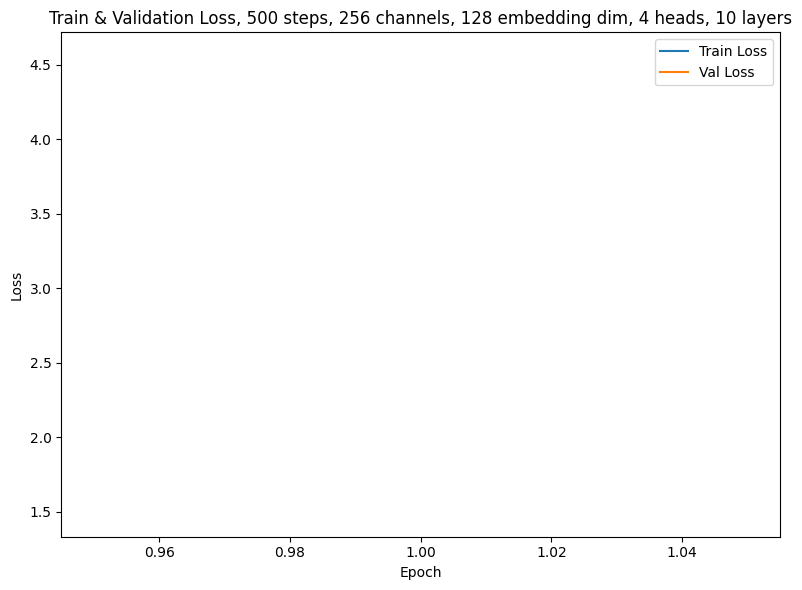

In [2]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from models.diff_modules import diff_CSDI
from models.diff_model import DiffusionTrajectoryModel
from models.encoder import InteractionGraphEncoder, TargetTrajectoryEncoder
from make_dataset import MultiMatchSoccerDataset, organize_and_process
from utils.utils import set_evertyhing, worker_init_fn, generator, plot_trajectories_on_pitch
from utils.data_utils import split_dataset_indices, custom_collate_fn
from utils.graph_utils import build_graph_sequence_from_condition

# 1. Hyperparameter Setting
# raw_data_path = "Download raw file path"
raw_data_path = "idsse-data"
data_save_path = "match_data"
batch_size = 32
num_workers = 8
epochs = 1
learning_rate = 2e-4
num_samples = 1
SEED = 42
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["CUDA_LAUNCH_BLOCKING"]   = "1"

set_evertyhing(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

csdi_config = {
    "num_steps": 500,
    "channels": 256,
    "diffusion_embedding_dim": 128,
    "nheads": 4,
    "layers": 10,
    # "side_dim": 128
    "side_dim": 256
}

# 2. Data Loading
print("---Data Loading---")
if not os.path.exists(data_save_path) or len(os.listdir(data_save_path)) == 0:
    organize_and_process(raw_data_path, data_save_path)
else:
    print("Skip organize_and_process")

dataset = MultiMatchSoccerDataset(data_root=data_save_path)
train_idx, val_idx, test_idx = split_dataset_indices(dataset, val_ratio=1/6, test_ratio=1/6, random_seed=SEED)

train_dataloader = DataLoader(
    Subset(dataset, train_idx),
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=False,
    collate_fn=custom_collate_fn,
    worker_init_fn=worker_init_fn,
    generator=generator(SEED)
)

val_dataloader = DataLoader(
    Subset(dataset, val_idx),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=False,
    collate_fn=custom_collate_fn,
    worker_init_fn=worker_init_fn,
)

test_dataloader = DataLoader(
    Subset(dataset, test_idx),
    batch_size=16,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=False,
    collate_fn=custom_collate_fn,
    worker_init_fn=worker_init_fn
)

print("---Data Load!---")

# 3. Model Define
# Extract node feature dimension
sample = dataset[0]
graph = build_graph_sequence_from_condition({
    "condition": sample["condition"],
    "condition_columns": sample["condition_columns"],
    "pitch_scale": sample["pitch_scale"]
}).to(device)
in_dim = graph['Node'].x.size(1)

# Extract target's history trajectories from condition
condition_columns = sample["condition_columns"]
target_columns = sample["target_columns"]
target_idx = [condition_columns.index(col) for col in target_columns if col in condition_columns]

graph_encoder = InteractionGraphEncoder(in_dim=in_dim, hidden_dim=128, out_dim=128, heads = 2).to(device)
history_encoder = TargetTrajectoryEncoder(num_layers=5).to(device)
denoiser = diff_CSDI(csdi_config)
model = DiffusionTrajectoryModel(denoiser, num_steps=csdi_config["num_steps"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=1e-4)
# 4. Train
best_state_dict = None
best_val_loss = float("inf")

train_losses = []
val_losses   = []

for epoch in tqdm(range(1, epochs + 1), desc="Training..."):
    model.train()
    train_noise_loss = 0
    train_mse_loss = 0
    train_frechet_loss = 0
    train_loss = 0

    for batch in tqdm(train_dataloader, desc = "Batch Training..."):
        cond = batch["condition"].to(device)
        B, T, _ = cond.shape
        target = batch["target"].to(device).view(-1, T, 11, 2)  # [B, T, 11, 2]
        graph_batch = batch["graph"].to(device)                              # HeteroData batch

        # graph → H
        H = graph_encoder(graph_batch)                                       # [B, 128]
        cond_H = H.unsqueeze(-1).unsqueeze(-1).expand(-1, H.size(1), 11, T)
        
        # Target's history trajectories
        hist = cond[:, :, target_idx].to(device) 
        hist_rep = history_encoder(hist)  # [B, 128]
        cond_hist = hist_rep.unsqueeze(-1).unsqueeze(-1).expand(-1, 128, 11, T)
        
        # Concat conditions
        cond_info = torch.cat([cond_H, cond_hist], dim=1)
        # Preparing Self-conditioning data
        if torch.rand(1, device=device) < 0.5:
            s = torch.zeros_like(target)
        else:
            with torch.no_grad():
                t = torch.randint(0, model.num_steps, (target.size(0),), device=device)
                x_t, noise = model.q_sample(target, t)
                x_t = x_t.permute(0,3,2,1)
                eps_pred1 = model.model(x_t, t, cond_info, self_cond=None)
                a_hat = model.alpha_hat.to(device)[t].view(-1,1,1,1)
                x0_hat = (x_t - (1 - a_hat).sqrt() * eps_pred1) / a_hat.sqrt()
                x0_hat = x0_hat.permute(0,3,2,1)
            s = x0_hat
        
        noise_loss, player_loss_mse, player_loss_frechet = model(target, cond_info=cond_info, self_cond=s)
        loss = noise_loss + player_loss_mse + player_loss_frechet * 2
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_noise_loss += noise_loss.item()
        train_mse_loss += player_loss_mse.item()
        train_frechet_loss += (player_loss_frechet * 2).item()
        train_loss += loss.item()

    num_batches = len(train_dataloader)
    
    avg_noise_loss = train_noise_loss / num_batches
    avg_mse_loss = train_mse_loss / num_batches
    avg_frechet_loss = train_frechet_loss / num_batches
    avg_train_loss = train_loss / num_batches

    # --- Validation ---
    model.eval()
    val_noise_loss = 0
    val_mse_loss = 0
    val_frechet_loss = 0
    val_total_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation"):
            cond = batch["condition"].to(device)
            B, T, _ = cond.shape
            target = batch["target"].to(device).view(-1, T, 11, 2)  # [B, T, 11, 2]
            graph_batch = batch["graph"].to(device)                              # HeteroData batch

            # graph → H
            H = graph_encoder(graph_batch)                                       # [B, 128]
            cond_H = H.unsqueeze(-1).unsqueeze(-1).expand(-1, H.size(1), 11, T)
            
            # Target's history trajectories
            hist = cond[:, :, target_idx].to(device)  # [B,128,11,T]
            hist_rep = history_encoder(hist)  # [B, 128]
            cond_hist = hist_rep.unsqueeze(-1).unsqueeze(-1).expand(-1, 128, 11, T)
            
            # Concat conditions
            cond_info = torch.cat([cond_H, cond_hist], dim=1)
            
            s = torch.zeros_like(target)
            
            noise_loss, player_loss_mse, player_loss_frechet = model(target, cond_info=cond_info, self_cond=s)
            val_loss = noise_loss + player_loss_mse + player_loss_frechet * 2
            
            val_noise_loss += noise_loss.item()
            val_mse_loss += player_loss_mse.item()
            val_frechet_loss += (player_loss_frechet * 2).item()
            val_total_loss += val_loss.item()

    avg_val_noise_loss = val_noise_loss / len(val_dataloader)
    avg_val_mse_loss = val_mse_loss / len(val_dataloader)
    avg_val_frechet_loss = val_frechet_loss / len(val_dataloader)
    avg_val_loss = val_total_loss / len(val_dataloader)
  
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    tqdm.write(f"[Epoch {epoch}]\nCost: {avg_train_loss:.6f} |"
               f"[Train] Noise Loss: {avg_noise_loss:.6f} | MSE Loss: {avg_mse_loss:.6f} | Frechet Loss: {avg_frechet_loss:.6f} | LR: {scheduler.get_last_lr()[0]:.6f}\n"
               f"[Validation] Val Loss: {avg_val_loss:.6f} | Noise: {avg_val_noise_loss:.6f} | MSE: {avg_val_mse_loss:.6f} | Frechet: {avg_val_frechet_loss:.6f}")
    scheduler.step(avg_val_loss)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_state_dict = model.state_dict()
        
# 4-1. Plot learning_curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f"Train & Validation Loss, {csdi_config['num_steps']} steps, {csdi_config['channels']} channels, "
          f"{csdi_config['diffusion_embedding_dim']} embedding dim, {csdi_config['nheads']} heads, {csdi_config['layers']} layers")
plt.legend()
plt.tight_layout()

plt.savefig('results/0424_diffusion_lr_curve.png')

plt.show()

In [ ]:

# 5. Validation Inference (Best-of-N Sampling) & Visualization
model.load_state_dict(best_state_dict)
model.eval()
all_best_ades = []
all_best_fdes = []
visualize_samples = 5
visualized = False

with torch.no_grad():
    for batch in tqdm(val_dataloader, desc="Val Streaming Inference"):
        cond = batch["condition"].to(device)
        B, T, _ = cond.shape
        target = batch["target"].to(device).view(B, T, 11, 2)

        # Graph → H
        graph_batch = batch["graph"].to(device)
        H = graph_encoder(graph_batch)
        cond_H = H.unsqueeze(-1).unsqueeze(-1).expand(-1, H.size(1), 11, T)

        # History → cond_hist
        hist = cond[:, :, target_idx].to(device)
        hist_rep  = history_encoder(hist)
        cond_hist = hist_rep.unsqueeze(-1).unsqueeze(-1).expand(-1, 128, 11, T)

        cond_info = torch.cat([cond_H, cond_hist], dim=1)
        best_ade_batch = torch.full((B,), float("inf"), device=device)
        best_pred_batch= torch.zeros_like(target)
        best_fde_batch = torch.full((B,), float("inf"), device=device)
        
        scales = torch.tensor(batch["pitch_scale"], device=device, dtype=torch.float32)  
        scales = scales.view(B, 1, 1, 2)

        for _ in tqdm(range(num_samples), desc="Generating..."):  # num_samples = 10
            pred_i = model.generate(shape=target.shape, cond_info=cond_info, num_samples=1)[0]  # (B, T, 11, 2)
            
            pred_i_den = pred_i * scales
            target_den = target * scales
            
            # ADE/FDE 계산
            ade_i = ((pred_i_den - target_den)**2).sum(-1).sqrt().mean((1,2))
            fde_i = ((pred_i_den[:,-1] - target_den[:,-1])**2).sum(-1).sqrt().mean(1)

            better = ade_i < best_ade_batch
            
            best_pred_batch[better] = pred_i_den[better]
            best_ade_batch[better] = ade_i[better]
            best_fde_batch[better] = fde_i[better]

        all_best_ades.extend(best_ade_batch.cpu().tolist())
        all_best_fdes.extend(best_fde_batch.cpu().tolist())

        # Visualization
        if not visualized:
            base_dir = "results/val_trajs"
            os.makedirs(base_dir, exist_ok=True)
            for i in range(min(B, visualize_samples)):
                sample_dir = os.path.join(base_dir, f"sample{i:02d}")
                os.makedirs(sample_dir, exist_ok=True)
                
                other_cols  = batch["other_columns"][i]
                target_cols = batch["target_columns"][i]
                defender_nums = [int(col.split('_')[1]) for col in target_cols[::2]]

                others_seq = batch["other"][i].view(T, 12, 2).cpu().numpy()
                target_traj = target_den[i].cpu().numpy()
                pred_traj = best_pred_batch[i].cpu().numpy()

                for idx, jersey in enumerate(defender_nums):
                    save_path = os.path.join(sample_dir, f"player_{jersey:02d}.png")
                    plot_trajectories_on_pitch(others_seq, target_traj, pred_traj,
                                               other_columns=other_cols, target_columns=target_cols,
                                               player_idx=idx, annotate=True, save_path=save_path)

            visualized = True

# 최종 결과 출력
avg_val_ade = np.mean(all_best_ades)
avg_val_fde = np.mean(all_best_fdes)
print(f"[Val Best-of-{num_samples}] Average ADE: {avg_val_ade:.4f} | Average FDE: {avg_val_fde:.4f}")
print(f"[Val Best-of-{num_samples}] Best ADE overall: {min(all_best_ades):.4f} | Best FDE overall: {min(all_best_fdes):.4f}")

Val Streaming Inference:   0%|          | 0/39 [00:52<?, ?it/s]

Generating...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating...:   0%|          | 0/1 [00:00<?, ?it/s]

Generating...:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
print("other_cols:", other_cols)
print("defender_cols:", target_cols[::2])
for idx, jersey in enumerate(defender_nums):
    print(idx, jersey)

other_cols: ['Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x', 'Away_21_x']
defender_cols: ['Home_1_x', 'Home_1_x', 'Home_1_x', 'Home_1_x', 'Home_1_x', 'Home_1_x', 'Home_1_x', 'Home_1_x', 'Home_1_x', 'Home_1_x', 'Home_1_x', 'Home_1_x', 'Home_1_x', 'Home_1_x', 'Home_1_x', 'Home_1_x']
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1


In [ ]:

# 5. Inference (Best-of-N Sampling) & Visualization
model.eval()
all_best_ades_test = []
all_best_fdes_test = []
visualized = False

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Test Streaming Inference"):
        cond = batch["condition"].to(device)
        B, T, _ = cond.shape
        target = batch["target"].to(device).view(B, T, 11, 2)

        graph_batch  = batch["graph"].to(device)
        H = graph_encoder(graph_batch)
        cond_H = H.unsqueeze(-1).unsqueeze(-1).expand(-1, H.size(1), 11, T)
        
        hist = cond[:, :, target_idx].to(device)
        hist_rep = history_encoder(hist)
        cond_hist = hist_rep.unsqueeze(-1).unsqueeze(-1).expand(-1, 128, 11, T)
        cond_info = torch.cat([cond_H, cond_hist], dim=1)

        best_ade_t = torch.full((B,), float("inf"), device=device)
        best_pred_t = torch.zeros_like(target)
        best_fde_t = torch.full((B,), float("inf"), device=device)
                    
        scales = torch.tensor(batch["pitch_scale"], device=device, dtype=torch.float32)  
        scales = scales.view(B, 1, 1, 2)

        for _ in tqdm(range(num_samples), desc="Generating..."):
            pred_i = model.generate(shape=target.shape, cond_info=cond_info, num_samples=1)[0]

            pred_i_den = pred_i * scales
            target_den = target * scales
            
            ade_i = ((pred_i_den - target_den)**2).sum(-1).sqrt().mean((1,2))
            fde_i = ((pred_i_den[:,-1] - target_den[:,-1])**2).sum(-1).sqrt().mean(1)
            
            better = ade_i < best_ade_t
            
            best_pred_t[better] = pred_i_den[better]
            best_ade_t[better] = ade_i[better]
            best_fde_t[better] = fde_i[better]

        all_best_ades_test.extend(best_ade_t.cpu().tolist())
        all_best_fdes_test.extend(best_fde_t.cpu().tolist())

        # Visualization
        if not visualized:
            base_dir = "results/test_trajs"
            os.makedirs(base_dir, exist_ok=True)
            for i in range(min(B, visualize_samples)):
                sample_dir = os.path.join(base_dir, f"sample{i:02d}")
                os.makedirs(sample_dir, exist_ok=True)
                
                other_cols  = batch["other_columns"][i]
                target_cols = batch["target_columns"][i]
                defender_nums = [int(col.split('_')[1]) for col in target_cols[::2]]

                others_seq = batch["other"][i].view(T, 12, 2).cpu().numpy()
                target_traj = target_den[i].cpu().numpy()
                pred_traj = best_pred_batch[i].cpu().numpy()

                for idx, jersey in enumerate(defender_nums):
                    save_path = os.path.join(sample_dir, f"player_{jersey:02d}.png")
                    plot_trajectories_on_pitch(others_seq, target_traj, pred_traj,
                                               other_columns=other_cols, target_columns=target_cols,
                                               player_idx=idx, annotate=True, save_path=save_path)

            visualized = True

avg_test_ade = np.mean(all_best_ades_test)
avg_test_fde = np.mean(all_best_fdes_test)
print(f"[Test Best-of-{num_samples}] Average ADE: {avg_test_ade:.4f} | Average FDE: {avg_test_fde:.4f}")
print(f"[Test Best-of-{num_samples}] Best ADE overall: {min(all_best_ades_test):.4f} | Best FDE overall: {min(all_best_fdes_test):.4f}")

ERROR:tornado.general:SEND Error: Host unreachable


Test Streaming Inference:   0%|          | 0/98 [01:56<?, ?it/s]

Exception ignored in: <generator object extract_node_features.<locals>.<listcomp>.<genexpr> at 0x7f52c00bc350>
Traceback (most recent call last):
  File "/home/park/workspace/SportsScience/Soccer-Trajectory-Prediction/utils/graph_utils.py", line 34, in <genexpr>
    attk_bases = [base for base in player_bases if "Attk" in base or any(f"{base}_position" in col for col in condition_columns[:22*7])][:11]
  File "_pydevd_bundle\\pydevd_cython.pyx", line 1697, in _pydevd_bundle.pydevd_cython.SafeCallWrapper.__call__
  File "_pydevd_bundle\\pydevd_cython.pyx", line 2074, in _pydevd_bundle.pydevd_cython.ThreadTracer.__call__
  File "/home/park/anaconda3/envs/SoccerTraj/lib/python3.10/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 1363, in apply_files_filter
    def apply_files_filter(self, frame, original_filename, force_check_project_scope):
KeyboardInterrupt: 


KeyboardInterrupt: 